In [1]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

import sys
import numpy as np
import tensorflow as tf
import os
import json

from distutils.version import StrictVersion
from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("./models/research")
from object_detection.utils import ops as utils_ops

if StrictVersion(tf.__version__) < StrictVersion('1.9.0'):
  raise ImportError('Please upgrade your TensorFlow installation to v1.9.* or later!')

# This is needed to display the images.
%matplotlib inline

/home/rajrup/miniconda3/envs/actdet/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/rajrup/miniconda3/envs/actdet/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/rajrup/miniconda3/envs/actdet/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/rajrup/miniconda3/envs/actdet/lib/pyt

In [2]:
from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

In [3]:
# Config File for the Resnet Model
CONFIG_FILE = "./cfg/config.json"

DS_HOME = './modules_actdet/deep_sort'
sys.path.append(DS_HOME)

import reid_nets.resnet_v1_50 as model
import reid_heads.fc1024 as head

SSD_THRES = 0.4
SSD_NMS = 0.45
SSD_NET_SHAPE = (512, 512)
SSD_PEOPLE_LABEL = 15

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [4]:
MODEL_NAME = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL_NAME + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_FROZEN_GRAPH = MODEL_NAME + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('./models/research/object_detection/data', 'mscoco_label_map.pbtxt')

In [5]:
opener = urllib.request.URLopener()
opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)
tar_file = tarfile.open(MODEL_FILE)
for file in tar_file.getmembers():
  file_name = os.path.basename(file.name)
  if 'frozen_inference_graph.pb' in file_name:
    tar_file.extract(file, os.getcwd())

In [6]:
detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_FROZEN_GRAPH, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')

In [7]:
category_index = label_map_util.create_category_index_from_labelmap(PATH_TO_LABELS, use_display_name=True)

In [20]:
def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [8]:
category_index

{1: {'id': 1, 'name': 'person'},
 2: {'id': 2, 'name': 'bicycle'},
 3: {'id': 3, 'name': 'car'},
 4: {'id': 4, 'name': 'motorcycle'},
 5: {'id': 5, 'name': 'airplane'},
 6: {'id': 6, 'name': 'bus'},
 7: {'id': 7, 'name': 'train'},
 8: {'id': 8, 'name': 'truck'},
 9: {'id': 9, 'name': 'boat'},
 10: {'id': 10, 'name': 'traffic light'},
 11: {'id': 11, 'name': 'fire hydrant'},
 13: {'id': 13, 'name': 'stop sign'},
 14: {'id': 14, 'name': 'parking meter'},
 15: {'id': 15, 'name': 'bench'},
 16: {'id': 16, 'name': 'bird'},
 17: {'id': 17, 'name': 'cat'},
 18: {'id': 18, 'name': 'dog'},
 19: {'id': 19, 'name': 'horse'},
 20: {'id': 20, 'name': 'sheep'},
 21: {'id': 21, 'name': 'cow'},
 22: {'id': 22, 'name': 'elephant'},
 23: {'id': 23, 'name': 'bear'},
 24: {'id': 24, 'name': 'zebra'},
 25: {'id': 25, 'name': 'giraffe'},
 27: {'id': 27, 'name': 'backpack'},
 28: {'id': 28, 'name': 'umbrella'},
 31: {'id': 31, 'name': 'handbag'},
 32: {'id': 32, 'name': 'tie'},
 33: {'id': 33, 'name': 'suitc

In [21]:
# For the sake of simplicity we will use only 2 images:
# image1.jpg
# image2.jpg
# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = './models/research/object_detection/test_images'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 3) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)

In [22]:
def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      print(tensor_dict.keys())
    #   if 'detection_masks' in tensor_dict:
    #     # The following processing is only for single image
    #     detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
    #     detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
    #     # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
    #     real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
    #     detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
    #     detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
    #     detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
    #         detection_masks, detection_boxes, image.shape[0], image.shape[1])
    #     detection_masks_reframed = tf.cast(
    #         tf.greater(detection_masks_reframed, 0.5), tf.uint8)
    #     # Follow the convention by adding back the batch dimension
    #     tensor_dict['detection_masks'] = tf.expand_dims(
    #         detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict

dict_keys(['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes'])
dict_keys(['num_detections', 'detection_boxes', 'detection_scores', 'detection_classes'])


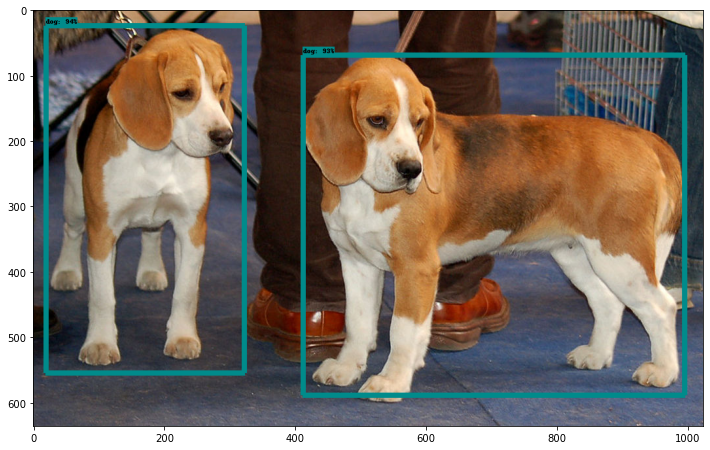

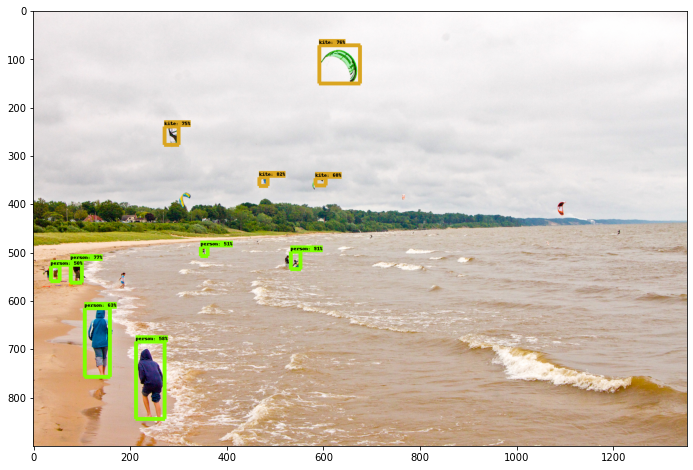

In [23]:
for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)

In [12]:
class REID:
    def Setup(self):
        config = json.loads(open(CONFIG_FILE, 'r').read())

        gpu_options = tf.GPUOptions(allow_growth=True)
        gpu_config = tf.ConfigProto(log_device_placement=False, gpu_options=gpu_options)
        self.sess = tf.InteractiveSession(config=gpu_config)

        # self.sess = tf.Session(config=gpu_config)
        net_input_size = (config['net_input_height'], config['net_input_width'])
        checkpoint_filename = os.path.join(config['experiment_root'], config['checkpoint_filename'])

        self.image = tf.placeholder(tf.float32, (None, net_input_size[0], net_input_size[1], 3))

        self.endpoints, _ = model.endpoints(self.image, is_training=False)
        with tf.name_scope('head'):
            self.endpoints = head.head(self.endpoints, config['embedding_dim'], is_training=False)

        self.sess.run(tf.global_variables_initializer())
        saver = tf.train.Saver()
        saver.restore(self.sess, checkpoint_filename)

        self.feature_dim = config['embedding_dim']
        self.image_shape = [config['net_input_height'], config['net_input_width']]

        self.log('init done')

    def log(self, s):
        print('[REID] %s' % s)


In [13]:
feature_extractor = REID()
feature_extractor.Setup()


INFO:tensorflow:Scale of 0 disables regularizer.

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from ././checkpoints/triplet-reid/checkpoint-25000
[REID] init done
